In [59]:
import nengo
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from simplified_stdp import STDP
from DataLog import DataLog
import tensorflow as tf
import os
from nengo.dists import Choice
from datetime import datetime
from nengo_extras.data import load_mnist
import pickle
plt.rcParams.update({'figure.max_open_warning': 0})

from nengo.utils.matplotlib import rasterplot


In [116]:
#############################
# load the data
#############################

img_rows, img_cols = 28, 28
input_nbr = 400

(image_train, label_train), (image_test, label_test) = (tf.keras.datasets.mnist.load_data())

#select the 0s and 1s as the two classes from MNIST data
image_train_filtered = []
label_train_filtered = []

x = 0
for i in range(0,input_nbr):
  if label_train[i] == x:
        image_train_filtered.append(image_train[i])
        label_train_filtered.append(label_train[i])
        if x == 0:
            x = 1
        else:
            x = 0

image_train_filtered = np.array(image_train_filtered)
label_train_filtered = np.array(label_train_filtered)

In [117]:
#############################
# Helpfull methodes
#############################

def sparsity_measure(vector):  # Gini index
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

def HeatMapSave(network,name,probe,samples=1,neuron=1):
    x = int(samples/100)

    if not os.path.exists(name):
        os.makedirs(name)

    plt.matshow(np.reshape(network.data[probe][:,neuron][samples-1],(28,28)))
    plt.title(samples-1)
    plt.savefig(name+"/"+str(neuron)+":"+str(samples-1)+".png")
    plt.cla()

def AllHeatMapSave(network,probe,folder,samples=1,neuron=1):

    if not os.path.exists(folder):
        os.makedirs(folder)
    
    os.makedirs(folder+"/"+str(neuron))
    i = 0
    step = samples / 100
    while i < samples:
        plt.matshow(np.reshape(network.data[probe][:,neuron][i],(28,28))) # , cmap=cm.jet
        plt.title(i)
        plt.savefig(folder+"/"+str(neuron)+"/"+str(neuron)+":"+str(i)+".png")
        plt.cla()
        i = int(i + step)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

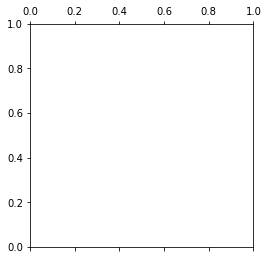

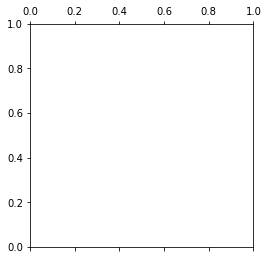

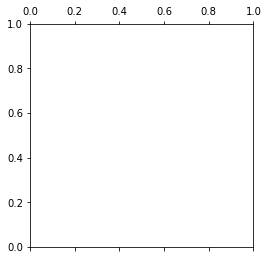

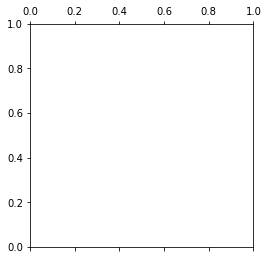

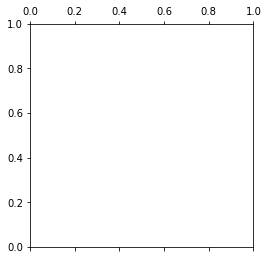

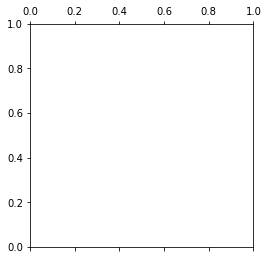

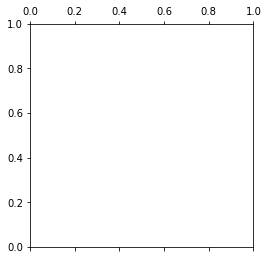

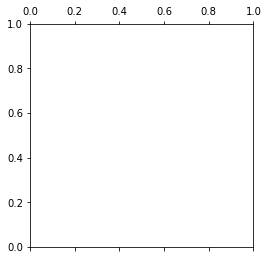

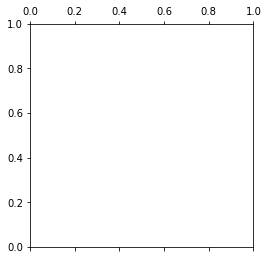

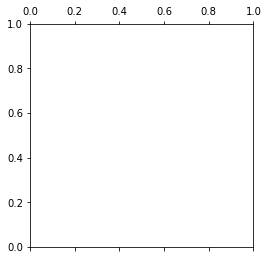

In [126]:
model = nengo.Network("My network")
#############################
# Model construction
#############################

presentation_time = 0.20 #0.35
#input layer

n_in = 784
n_neurons = 10

# log = DataLog()
with model:

    # input layer 
    picture = nengo.Node(nengo.processes.PresentInput(image_train_filtered, presentation_time))
    true_label = nengo.Node(nengo.processes.PresentInput(label_train_filtered, presentation_time))
    
    input_layer = nengo.Ensemble(
        784,
        1,
        label="input",
        max_rates=nengo.dists.Uniform(22, 22),
        intercepts=nengo.dists.Choice([0])
        )
    input_conn = nengo.Connection(picture,input_layer.neurons,synapse=None)

    # weights randomly initiated 
    layer1_weights = random.random((n_neurons, 784))
   
    #Noise 
    process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.5), seed=1)

    # define first layer
    layer1 = nengo.Ensemble(
         n_neurons,
         1,
         neuron_type=nengo.neurons.AdaptiveLIF(),
         label="layer1",
        noise=process,
         max_rates=nengo.dists.Uniform(20,80),
         intercepts=nengo.dists.Choice([0])
         )

   


    # define connection between the two layers
    conn1 = nengo.Connection(
        input_layer.neurons,
        layer1.neurons,
        transform=layer1_weights,
        synapse=None,
#         learning_rule_type = [nengo.BCM(learning_rate=5e-10),nengo.Oja(learning_rate=2e-9)]
        learning_rule_type=STDP()
        )

#     create inhibitory layer 
    layer1_inh = nengo.Ensemble(
         n_neurons,
         1,
         neuron_type=nengo.neurons.LIF(),
         label="layer1",
         max_rates=nengo.dists.Uniform(20,50),
         intercepts=nengo.dists.Choice([0])
         )
    
    exc_inh_wegihts = np.eye(n_neurons)
    inh_exc_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * -50
    
    conn_exc_inh = nengo.Connection(layer1.neurons, layer1_inh.neurons, transform=exc_inh_wegihts)
    conn_inh_exc = nengo.Connection(layer1_inh.neurons, layer1.neurons, transform=inh_exc_wegihts)
    
    
#     inhib_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * -100

#     inhib = nengo.Connection(layer1.neurons, layer1.neurons, transform=inhib_wegihts)
        
    #############################

    #############################
    # setup the probes
    #############################

    connection_layer1_probe = nengo.Probe(conn1,"weights",label="layer1_synapses") 
    
    p_true_label = nengo.Probe(true_label)
    p_layer_1 = nengo.Probe(layer1.neurons)

    nengo.Node(log)
    
with nengo.Simulator(model) as sim:

#     log.set(sim,"Log.txt",False,False)
    
    sim.run((presentation_time) * label_train_filtered.shape[0])

#save the model
pickle.dump(sim.data[connection_layer1_probe][-1], open( "mnist_params_STDP", "wb" ))
# log.closeLog()

now = str(datetime.now().time())
folder = "My Sim "+now

for i in range(0,(n_neurons)):
    HeatMapSave(sim,folder,connection_layer1_probe,sim.data[connection_layer1_probe].shape[0],i)
    
#     AllHeatMapSave(sim,connection_layer1_probe,folder,samples=10,neuron=1)

Text(0, 0.5, 'Neuron index')

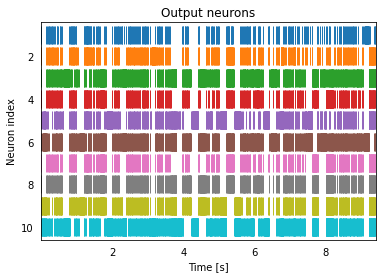

In [127]:
plt.title('Output neurons')
rasterplot(sim.trange(), sim.data[p_layer_1])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")

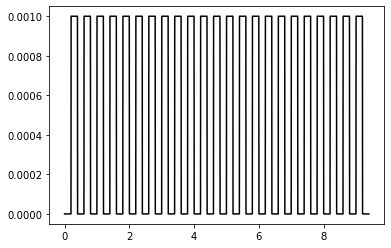

In [128]:
plt.plot(sim.trange(), sim.data[p_true_label]/1000, c='k', label='spikes')